In [175]:
import csv
import json
import mediapipe as mp
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
# Load the Mediapipe Hand Solution
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1)

# Create a dictionary to store the data
data = {'landmarks': [], 'labels': []}

# Loop over the images and extract the landmarks and labels
for label in ['close_hand', 'open_hand']:
    # Get the image paths and labels
    image_folder = f"/home/kalpit/Documents/dataset/{label}"
    image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
    labels = np.ones(len(image_paths)) if label == 'close_hand' else np.zeros(len(image_paths))

    # Loop over the images and extract the landmarks
    for image_path, label in zip(image_paths, labels):
        # Load the image
        image = cv2.imread(image_path)

        # Convert the image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image with Mediapipe
        results = mp_hands.process(image)

        # Extract the landmarks if they are present
        if results.multi_hand_landmarks:
            landmarks = [[float(landmark.x), float(landmark.y), float(landmark.z)] for landmark in results.multi_hand_landmarks[0].landmark]

            # Add the landmarks and label to the dictionary
            data['landmarks'].append(landmarks)
            data['labels'].append(label)

# Close the Mediapipe Hand Solution
mp_hands.close()

# Save the dictionary as a JSON file
with open('hand_landmarks.json', 'w') as f:
    json.dump(data, f)


In [176]:
# 1 is for closed
# lalel 0 is for open

In [177]:
# Load the data from the JSON file
data = pd.read_json('hand_landmarks.json')

# Reshape the landmarks data
landmarks = pd.concat([pd.DataFrame(x) for x in data["landmarks"].values], ignore_index=True)

# Split the data into features and labels
X = landmarks.values.reshape(-1, 21, 3)
X = X.reshape(X.shape[0], -1)
y = data["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [178]:
print(X.shape)
print(X_test.shape)


(3384, 63)
(677, 63)


In [179]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

# Define the model architecture
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, validation_data=(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test), epochs=50, batch_size=32)
# Evaluate the model
accuracy = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test)[1]
print('Accuracy:', accuracy)


Epoch 1/50


/home/kalpit/.local/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


85/85 [==============================] - 1s 7ms/step - loss: 0.6917 - accuracy: 0.5356 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 2/50
85/85 [==============================] - 0s 5ms/step - loss: 0.6754 - accuracy: 0.5578 - val_loss: 0.5443 - val_accuracy: 0.8316
Epoch 3/50
85/85 [==============================] - 0s 6ms/step - loss: 0.3990 - accuracy: 0.8386 - val_loss: 0.2197 - val_accuracy: 0.9040
Epoch 4/50
85/85 [==============================] - 0s 5ms/step - loss: 0.1859 - accuracy: 0.9239 - val_loss: 0.0827 - val_accuracy: 0.9705
Epoch 5/50
85/85 [==============================] - 0s 5ms/step - loss: 0.1244 - accuracy: 0.9586 - val_loss: 0.0396 - val_accuracy: 0.9911
Epoch 6/50
85/85 [==============================] - 1s 6ms/step - loss: 0.0874 - accuracy: 0.9664 - val_loss: 0.0476 - val_accuracy: 0.9838
Epoch 7/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0658 - accuracy: 0.9804 - val_loss: 0.0402 - val_accuracy: 0.9867
Epoch 8/50
85/85 [=============

<AxesSubplot:>

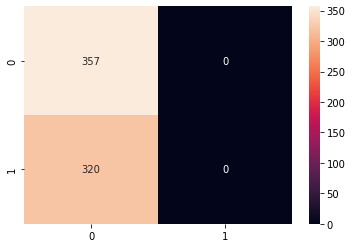

In [180]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions for X_test
# Generate predictions for X_test
y_pred_prob = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
y_pred = np.argmax(y_pred_prob, axis=1)

# y_pred = model.predict_classes(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap of confusion matrix
sns.heatmap(cm, annot=True, fmt='d')


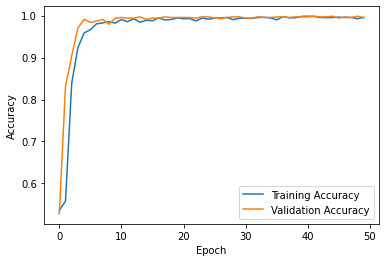

In [181]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [182]:
import tensorflow as tf

# Convert the Keras model to a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('hand_classifier_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkstkd3ip/assets


INFO:tensorflow:Assets written to: /tmp/tmpkstkd3ip/assets
2023-04-20 18:49:50.849247: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-04-20 18:49:50.849276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-04-20 18:49:50.849439: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpkstkd3ip
2023-04-20 18:49:50.851865: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-04-20 18:49:50.851886: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpkstkd3ip
2023-04-20 18:49:50.859809: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-04-20 18:49:50.912835: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpkstkd3ip
2023-04-20 18:49:50.931001: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

In [183]:
import cv2
import mediapipe as mp
import numpy as np
# Load the Mediapipe Hand Solution
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1)

# Load the image
image = cv2.imread("/home/kalpit/Documents/dataset/thumb.png")

# Convert the image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process the image with Mediapipe
results = mp_hands.process(image)

# Extract the landmarks if they are present
if results.multi_hand_landmarks:
    # Extract the landmarks
    landmarks = [[float(landmark.x), float(landmark.y), float(landmark.z)] for landmark in results.multi_hand_landmarks[0].landmark]
    # Reshape the landmarks
    # print(landmarks)
    X = np.array(landmarks).reshape(-1, 21, 3)
    X = X.reshape(X.shape[0], -1)
    # Make a prediction
    y_pred = model.predict(X)
    print(y_pred)
    # Print the predicted label
    if y_pred > 0.5:
        print("closed hand")
    else:
        print("open hand")

# Close the Mediapipe Hand Solution
mp_hands.close()


[[1.]]
closed hand
